# **Importing libraries**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import librosa
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

from tqdm import tqdm
%matplotlib inline

from torchsummary import summary


# Get Computtional Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Importing the Dataset

In [3]:
# Percorso base del dataset RAVDESS su Kaggle
# (Kaggle salva automaticamente i dataset nella cartella /kaggle/input/)
DATASET_PATH = "/kaggle/input/datasets/uwrfkaggler/ravdess-emotional-speech-audio"

# Mappatura delle emozioni (il 3° numero nel nome del file RAVDESS)
emotion_map = {
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'
}

print("Librerie importate con successo!")

Librerie importate con successo!


In [4]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset

class RavdessDataset(Dataset):
    def __init__(self, root_dir=DATASET_PATH, subset="training", emotions=None):
        """
        emotions: lista di stringhe con i codici delle emozioni da tenere (es. ["03", "04"] per Felice e Triste).
                  Se None, prende tutte le emozioni.
        """
        self.root_dir = root_dir
        self.emotions = emotions if emotions is not None else []
        self._walker = [] # Conterrà i percorsi dei file audio selezionati

        # 1. Trova tutti i file .wav nelle sottocartelle
        all_files = []
        for dirpath, _, filenames in os.walk(root_dir):
            for f in filenames:
                if f.endswith(".wav"):
                    all_files.append(os.path.join(dirpath, f))

        # 2. Filtra e suddividi il dataset
        for file_path in all_files:
            filename = os.path.basename(file_path)
            
            # Rimuove ".wav" e divide la stringa usando i trattini
            parts = filename.replace(".wav", "").split("-")
            
            # Controlla che il file sia effettivamente nel formato RAVDESS (7 parti)
            if len(parts) != 7:
                continue
                
            emotion = parts[2]
            actor = int(parts[6]) # Convertiamo in intero per fare i confronti (es. "05" diventa 5)

            # Filtra per etichetta (emozione)
            if len(self.emotions) > 0 and emotion not in self.emotions:
                continue # Salta questo file e passa al prossimo

            # Suddivide per Actor (Previene il data leakage)
            if subset == "training" and actor <= 18:
                self._walker.append(file_path)
            elif subset == "validation" and 19 <= actor <= 22:
                self._walker.append(file_path)
            elif subset == "testing" and actor >= 23:
                self._walker.append(file_path)
            elif subset is None:
                self._walker.append(file_path) # Carica tutto se subset non è specificato

    def __len__(self):
        # PyTorch ha bisogno di sapere quanto è grande il dataset
        return len(self._walker)

    def __getitem__(self, idx):
        file_path = self._walker[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Prende il nome del file (es: "03-01-05-01-02-01-12.wav")
        filename = os.path.basename(file_path)
        
        # Toglie l'estensione e divide i pezzi
        parts = filename.replace(".wav", "").split("-")
        
        # Estrae i vari ID dal nome del file
        emotion_label = parts[2]
        utterance_number = int(parts[4])  # Frase 1 o 2
        speaker_id = int(parts[6])        # Attore da 1 a 24
        
        # Converte l'etichetta dell'emozione in un tensore
        label_tensor = torch.tensor(int(emotion_label) - 1, dtype=torch.long)
        
        # Ora restituisce anche speaker_id e utterance_number!
        return waveform, sample_rate, label_tensor, speaker_id, utterance_number

In [5]:
# Voglio solo Felicità (03) e Rabbia (05)
emozioni_scelte = ["03", "05"]

train_dataset = RavdessDataset(subset="training", emotions=emozioni_scelte)
val_dataset = RavdessDataset(subset="validation", emotions=emozioni_scelte)
test_dataset = RavdessDataset(subset="testing", emotions=emozioni_scelte)

print(f"File di training trovati: {len(train_dataset)}")
print(f"File di validation trovati: {len(val_dataset)}")

File di training trovati: 576
File di validation trovati: 128


# Esplorazione dei dati

Sample metadata. Label: 4, Speaker: 2, Utterance no. 1
Shape of waveform: torch.Size([1, 176176])
  Number of channels: 1
  Number of samples: 176176
Sample rate of waveform: 48000 Hz
Seconds: 3.6703333333333332 s


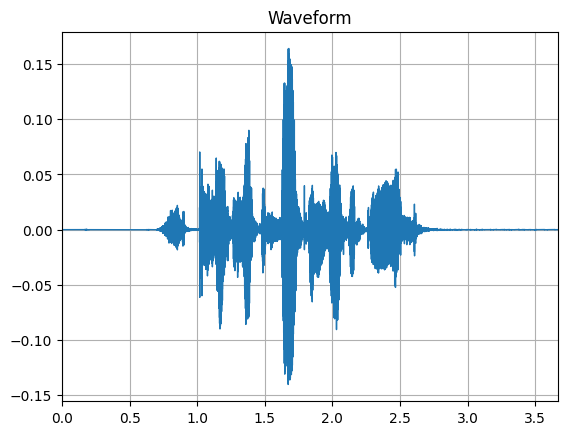

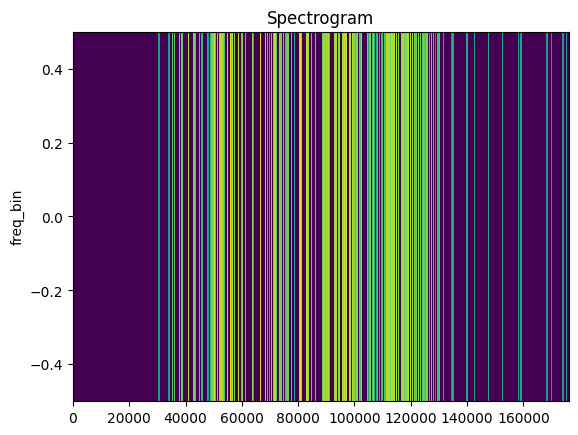

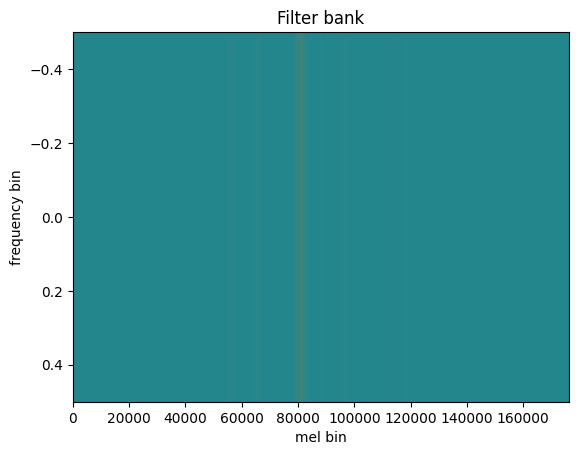

In [6]:
idx = 1 #seleziona un campione dal dataset es. indice=1

waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[idx]

print(f"Sample metadata. Label: {label}, Speaker: {speaker_id}, Utterance no. {utterance_number}")
print("Shape of waveform: {}".format(waveform.size()))
print("  Number of channels: {}".format(waveform.size()[0]))
print("  Number of samples: {}".format(waveform.size()[1]))
print("Sample rate of waveform: {} Hz".format(sample_rate))


# TASK: WAVEFORM PLOT

#traccia la forma d'onda e stampane la forma.
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

num_campioni=waveform.shape[1]
sec=num_campioni/sample_rate
print("Seconds: {} s".format(sec))

plot_waveform(waveform, sample_rate)
plot_spectrogram(waveform, title="Spectrogram")
plt.show()
plot_fbank(waveform, title="Filter bank")
plt.show()